In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

JUPYTER_PATH = Path.cwd()
PROJECT_ROOT = JUPYTER_PATH.parents[0]
os.chdir(PROJECT_ROOT)
print(f"Main Project Root: {os.getcwd()}")

Main Project Root: /Users/mungughyeon/Documents/contest/DACON_BDA


In [2]:
train_path = PROJECT_ROOT / "dataset/train.csv"
test_path = PROJECT_ROOT / "dataset/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"Train Dataset: {train.shape}")
print(f"Test Dataset: {test.shape}")

Train Dataset: (748, 46)
Test Dataset: (814, 45)


In [3]:
from src.preprocess import Pipeline
pipeline = Pipeline()
train, test, test_id = pipeline.run(train, test)

X = train.drop(columns=['completed'])
y = train['completed']

print(f"X: {X.shape[0]}")
print(f"y: {y.shape[0]}")

[Step1] 결측치 처리 완료
[Step2] completed_semester 처리 완료
[Step3] major 매핑 완료 (test only)
[Step4] ['generation', 'contest_award', 'idea_contest', 'contest_participation'] 제거 완료
[Step5] 자격증 인코딩 완료
[Step6] 기업 카테고리 인코딩 완료
[Step7] multi-hot 인코딩 완료
[Step8] 원본 컬럼 제거 완료
[Step9] label 인코딩 24개 컬럼 완료, ID 분리됨
[Step10] robust 스케일링 100개 컬럼 완료

전처리 완료: train (748, 102), test (814, 101)
X: 748
y: 748


### Model Select

In [4]:
from src.models import ModelComparator

comparator = ModelComparator(n_splits=10)                                                                                 
results_df = comparator.run(X, y)
results_df

LightGBM: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


  → LightGBM: OOF F1=0.4692, Mean Fold F1=0.5124±0.0406, Threshold=0.28


XGBoost: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


  → XGBoost: OOF F1=0.4292, Mean Fold F1=0.4581±0.0259, Threshold=0.12


CatBoost: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


  → CatBoost: OOF F1=0.4856, Mean Fold F1=0.5118±0.0497, Threshold=0.47


RandomForest: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


  → RandomForest: OOF F1=0.4617, Mean Fold F1=0.5019±0.0311, Threshold=0.19


ExtraTrees: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

  → ExtraTrees: OOF F1=0.4633, Mean Fold F1=0.4934±0.0407, Threshold=0.29


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4856,0.5118,0.0497,0.47
1,LightGBM,0.4692,0.5124,0.0406,0.28
2,ExtraTrees,0.4633,0.4934,0.0407,0.29
3,RandomForest,0.4617,0.5019,0.0311,0.19
4,XGBoost,0.4292,0.4581,0.0259,0.12


In [5]:
def save_submission(model, pred, filename='submission'):
    save_path = PROJECT_ROOT / "submissions"
    os.makedirs(save_path, exist_ok=True)

    sub = pd.DataFrame({'ID': test_id, 'completed': pred})                                                       
    sub.to_csv(f'{save_path}/{filename}.csv', index=False)  
                                                             
    print(f"Threshold: {model.best_threshold}")                                              
    print(f"Class 분포:\n{sub['completed'].value_counts()}")  

### Feature Importance

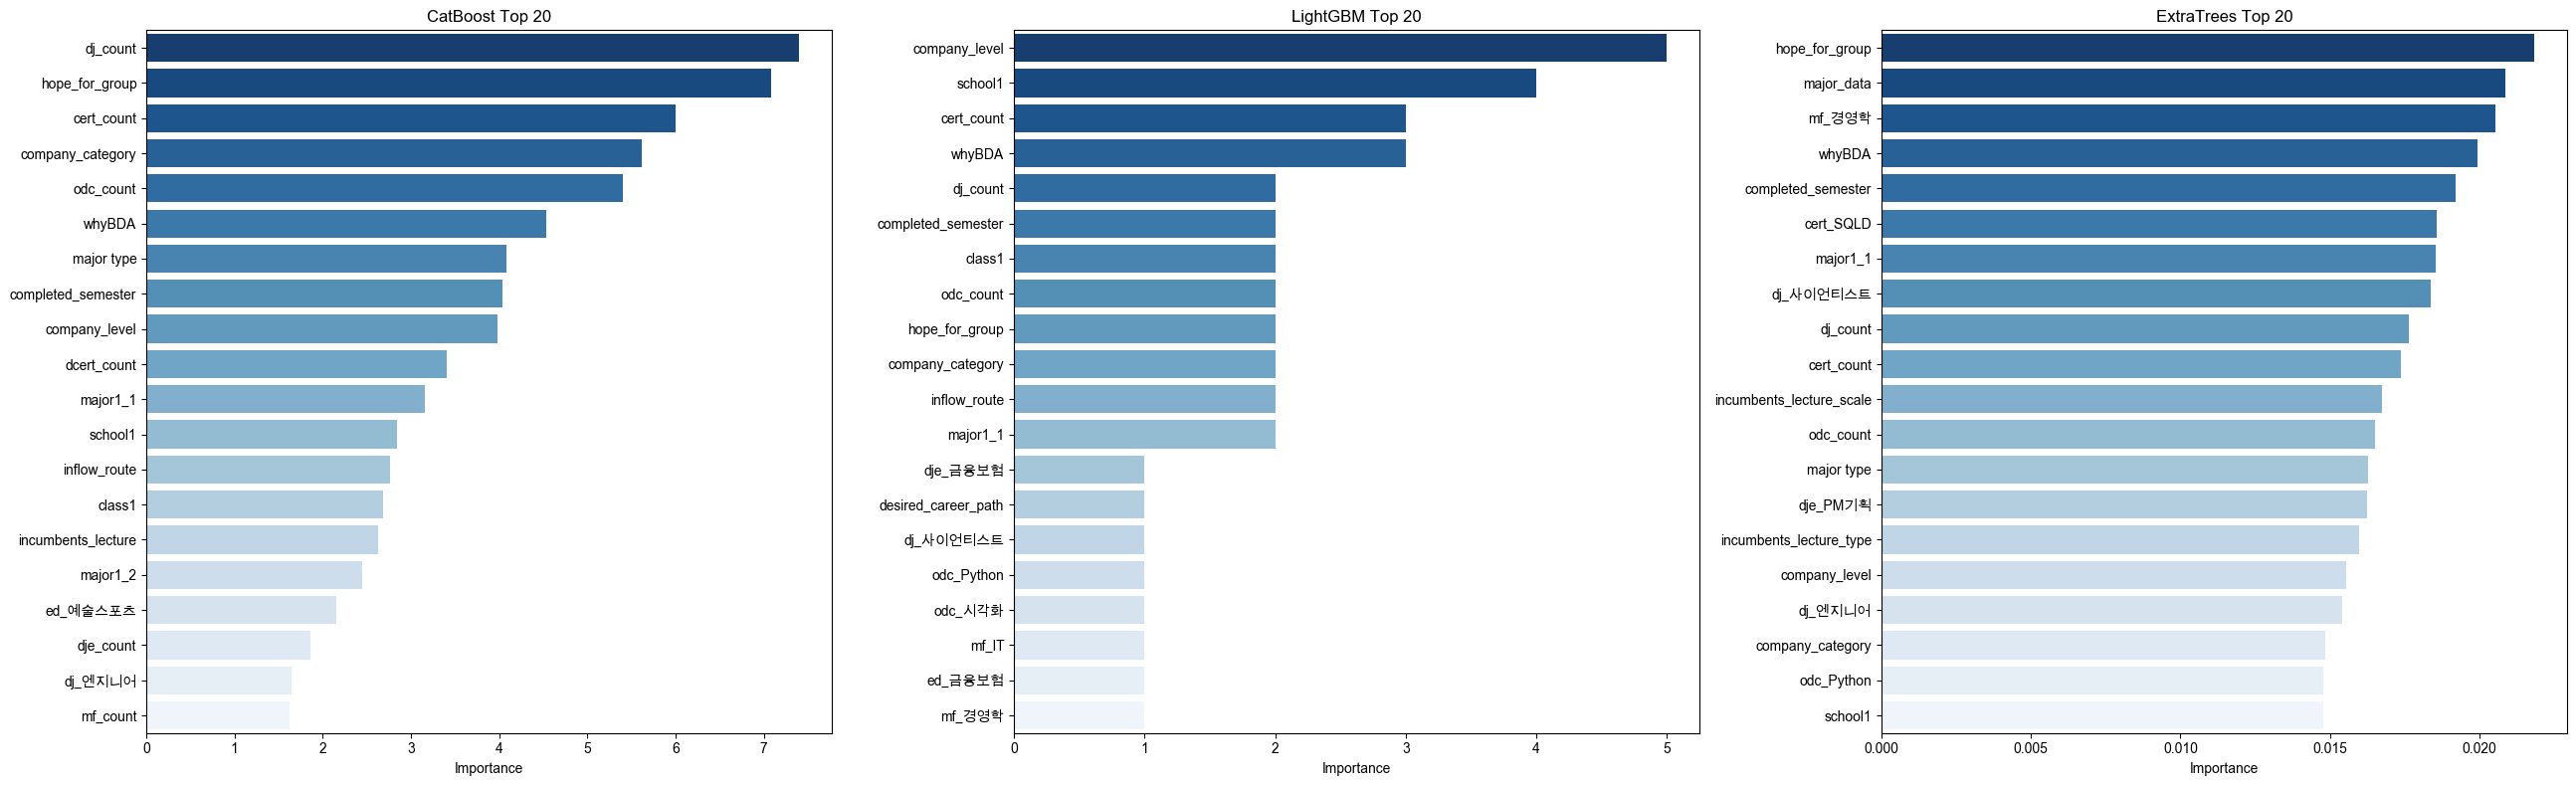

In [6]:
from src.visualization.plot import set_korean_font, bar_plot                                                     
set_korean_font()                                                                                              
                                                                                                                
top3 = ['CatBoost', 'LightGBM', 'ExtraTrees']                                                                    
top3_idx = [2, 0, 4]                                                                                             
top_n = 20

imp_dfs = {}
for i, name in zip(top3_idx, top3):
    m = comparator.models[i].models[0]
    imp = m.get_feature_importance() if name == 'CatBoost' else m.feature_importances_
    imp_dfs[name] = pd.DataFrame({
        'feature': X.columns, 'importance': imp
    }).sort_values('importance', ascending=False).reset_index(drop=True)

# ── Top 20 시각화 ──
fig, axes = plt.subplots(1, 3, figsize=(26, 8))
for ax, name in zip(axes, top3):
    df_top = imp_dfs[name].head(top_n).sort_values('importance', ascending=False)
    bar_plot(df_top, x_col='importance', y_col='feature', ax=ax, palette="Blues_r",
            title=f'{name} Top {top_n}', xlabel='Importance', show=False)
plt.tight_layout()
plt.show()

In [7]:
top_n = 20
bottom_n = 30

top_sets = {name: set(df.head(top_n)['feature']) for name, df in imp_dfs.items()}
bottom_sets = {name: set(df.tail(bottom_n)['feature']) for name, df in imp_dfs.items()}

top_common = set.intersection(*top_sets.values())
bottom_common = set.intersection(*bottom_sets.values())

print(f"\n★ Top {top_n} 교집합 ({len(top_common)}개):")
for f in sorted(top_common):
    print(f"  {f}")

print(f"\n★ Bottom {bottom_n} 교집합 ({len(bottom_common)}개):")
for f in sorted(bottom_common):
    print(f"  {f}")

zero_sets = {name: set(df[df['importance'] == 0]['feature']) for name, df in imp_dfs.items()}
zero_common = set.intersection(*zero_sets.values())
print(f"\n★ Importance=0 교집합 ({len(zero_common)}개):")
for f in sorted(zero_common):
    print(f"  {f}")


★ Top 20 교집합 (10개):
  cert_count
  company_category
  company_level
  completed_semester
  dj_count
  hope_for_group
  major1_1
  odc_count
  school1
  whyBDA

★ Bottom 30 교집합 (6개):
  dcert_컴퓨터활용능력
  mf_경제통상학
  mf_교육학
  mf_법학
  mf_예체능
  mf_의약학

★ Importance=0 교집합 (5개):
  class4
  dcert_컴퓨터활용능력
  nationality
  odc_AI모델
  odc_Hadoop


In [8]:
for name in ['CatBoost', 'LightGBM', 'ExtraTrees']:
    print(f"\n{name} Bottom 5:")
    print(imp_dfs[name].tail(5)[['feature', 'importance']].to_string(index=False))


CatBoost Bottom 5:
         feature  importance
incumbents_level         0.0
         dj_디자이너         0.0
    dcert_정보처리기사         0.0
        dje_금융보험         0.0
          mf_교육학         0.0

LightGBM Bottom 5:
         feature  importance
previous_class_3           0
     dcert_count           0
       dcert_태블로           0
   dcert_컴퓨터활용능력           0
         mf_자연과학           0

ExtraTrees Bottom 5:
      feature  importance
   odc_Hadoop         0.0
     odc_AI모델         0.0
dcert_컴퓨터활용능력         0.0
       class4         0.0
  nationality         0.0


In [11]:
drop_cols = list(set(bottom_common) | set(zero_common))
print(f"Drop Column Count: {len(drop_cols)}")
drop_cols

Drop Column Count: 10


['dcert_컴퓨터활용능력',
 'mf_예체능',
 'mf_의약학',
 'odc_AI모델',
 'mf_경제통상학',
 'odc_Hadoop',
 'nationality',
 'mf_교육학',
 'mf_법학',
 'class4']

In [9]:
from src.models import ModelComparator

X_v2 = X.drop(columns=zero_common)
test_v2 = test.drop(columns=zero_common)
print(f"Feature: {X.shape[1]} → {X_v2.shape[1]}")

Feature: 101 → 96


In [12]:
from src.models import ModelComparator

X_v2 = X.drop(columns=drop_cols)
test_v2 = test.drop(columns=drop_cols)
print(f"Feature: {X.shape[1]} → {X_v2.shape[1]}")

Feature: 101 → 91


In [10]:
comparator_v2 = ModelComparator(n_splits=10)
results_v2 = comparator_v2.run(X_v2, y)
results_v2

LightGBM: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


  → LightGBM: OOF F1=0.4692, Mean Fold F1=0.5124±0.0406, Threshold=0.28


XGBoost: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


  → XGBoost: OOF F1=0.4141, Mean Fold F1=0.4431±0.0305, Threshold=0.1


CatBoost: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


  → CatBoost: OOF F1=0.4927, Mean Fold F1=0.5235±0.0358, Threshold=0.4


RandomForest: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


  → RandomForest: OOF F1=0.4627, Mean Fold F1=0.5033±0.0268, Threshold=0.2


ExtraTrees: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

  → ExtraTrees: OOF F1=0.4632, Mean Fold F1=0.4931±0.0304, Threshold=0.27


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4927,0.5235,0.0358,0.40
1,LightGBM,0.4692,0.5124,0.0406,0.28
2,ExtraTrees,0.4632,0.4931,0.0304,0.27
3,RandomForest,0.4627,0.5033,0.0268,0.20
4,XGBoost,0.4141,0.4431,0.0305,0.10


In [ ]:
cat_model = comparator_v2.models[2]  # LGB=0, XGB=1, Cat=2, RF=3, ET=4                                              
cat_prob = cat_model.predict_proba(test_v2)                                                                         
cat_pred = (cat_prob >= cat_model.best_threshold).astype(int)

save_submission(cat_model, cat_pred, 'base-2_catboost')

Threshold: 0.44999999999999984
Class 분포:
completed
1    643
0    171
Name: count, dtype: int64


### Hyperparameters tuning

In [27]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, X_data, y_data):                                                                            
                                                                                                                
    pos_ratio = (y_data == 0).sum() / (y_data == 1).sum()                                                                                               
    params = {                                                                                                   
        'iterations': trial.suggest_int('iterations', 100, 3000),                                                
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 100.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'scale_pos_weight': trial.suggest_float(
            'scale_pos_weight',
            pos_ratio * 0.5,
            pos_ratio * 2.0
        ),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_seed': 42,
        'verbose': 0,
        'eval_metric': 'F1',  # F1 기준으로 조기 종료
    }

    rskf = RepeatedStratifiedKFold(
        n_splits=5,
        n_repeats=3,  # 충분히 탐색
        random_state=42
    )

    oof_probs = np.zeros(len(X_data))
    for train_idx, val_idx in rskf.split(X_data, y_data):
        model = CatBoostClassifier(**params)
        model.fit(
            X_data.iloc[train_idx],
            y_data.iloc[train_idx],
            eval_set=(X_data.iloc[val_idx], y_data.iloc[val_idx]),
            early_stopping_rounds=50,
        )
        probs = model.predict_proba(X_data.iloc[val_idx])[:, 1]
        oof_probs[val_idx] += probs / rskf.get_n_splits() # fold 내부에서 threshold 최적화하지 않고 확률만 저장

    # 전체 OOF 기준으로 threshold 단 1회 탐색
    thresholds = np.arange(0.10, 0.70, 0.01)
    best_f1 = max(
        f1_score(y_data, (oof_probs >= t).astype(int))
        for t in thresholds
    )
    return best_f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_v2, y), n_trials=500)

print(f"Best F1: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

  0%|          | 0/500 [00:00<?, ?it/s]

Best F1: 0.4848
Best params: {'iterations': 2709, 'learning_rate': 0.016409989701102558, 'depth': 6, 'l2_leaf_reg': 0.006995308692303946, 'border_count': 202, 'min_data_in_leaf': 42, 'subsample': 0.9740063099802131, 'colsample_bylevel': 0.2817519601361652, 'scale_pos_weight': 3.482436146222915, 'random_strength': 2.9812787578846294, 'bagging_temperature': 2.6806476710123417}


In [15]:
trials_df = study.trials_dataframe()[['number', 'value', 'params_scale_pos_weight',                  
                                        'params_depth', 'params_iterations',                         
                                        'params_learning_rate', 'params_l2_leaf_reg']]               
                                                                                                    
trials_df = trials_df.sort_values('value', ascending=False).head(10)                                 
trials_df.columns = ['trial', 'f1_score', 'scale_pos_weight', 'depth', 'iterations', 'lr', 'l2_leaf_reg']
trials_df

,trial,f1_score,scale_pos_weight,depth,iterations,lr,l2_leaf_reg
468,468,0.484848,3.482436,6,2709,0.016410,0.006995
319,319,0.484571,3.698179,6,2841,0.052190,0.019332
265,265,0.483945,3.158108,5,2912,0.013161,0.048863
492,492,0.482927,4.038607,7,2793,0.008964,0.001551
337,337,0.482436,3.426012,6,2958,0.009858,0.004298
496,496,0.482100,4.038460,7,2795,0.007154,0.001175
143,143,0.481928,4.394789,6,2804,0.024537,0.039809
499,499,0.481613,4.193183,7,2790,0.006937,0.001039
364,364,0.481613,3.498374,6,2804,0.058876,0.004718
348,348,0.481529,3.377669,7,2910,0.011687,0.005442


In [16]:
best_params = study.best_params                                                                      
best_params['random_seed'] = 42                                                                      
best_params['verbose'] = 0                                                                         

# CV로 OOF 예측 + test 예측 평균
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
oof_probs = np.zeros(len(X_v2))
test_probs = np.zeros(len(test_v2))

for fold, (train_idx, val_idx) in enumerate(rskf.split(X_v2, y)):
    model = CatBoostClassifier(**best_params)
    model.fit(
        X_v2.iloc[train_idx], y.iloc[train_idx],
        eval_set=(X_v2.iloc[val_idx], y.iloc[val_idx]),
        early_stopping_rounds=50,
    )
    oof_probs[val_idx] = model.predict_proba(X_v2.iloc[val_idx])[:, 1]
    test_probs += model.predict_proba(test_v2)[:, 1] / 10

# 최적 threshold 찾기
best_t, best_f1 = 0.5, 0.0
for t in np.arange(0.10, 0.70, 0.01):
    f1 = f1_score(y, (oof_probs >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"OOF F1: {best_f1:.4f}, Threshold: {best_t:.2f}")

pred = (test_probs >= best_t).astype(int)
sub = pd.DataFrame({'ID': test_id, 'completed': pred})

save_path = PROJECT_ROOT / "submissions"
os.makedirs(save_path, exist_ok=True)
sub.to_csv(f'{save_path}/cat_tuning_1.csv', index=False) 
print(f"Class 분포:\n{sub['completed'].value_counts()}")

OOF F1: 0.4659, Threshold: 0.49
Class 분포:
completed
1    814
Name: count, dtype: int64


정규성 만족 비율: 3.0% → SPEARMAN 선택


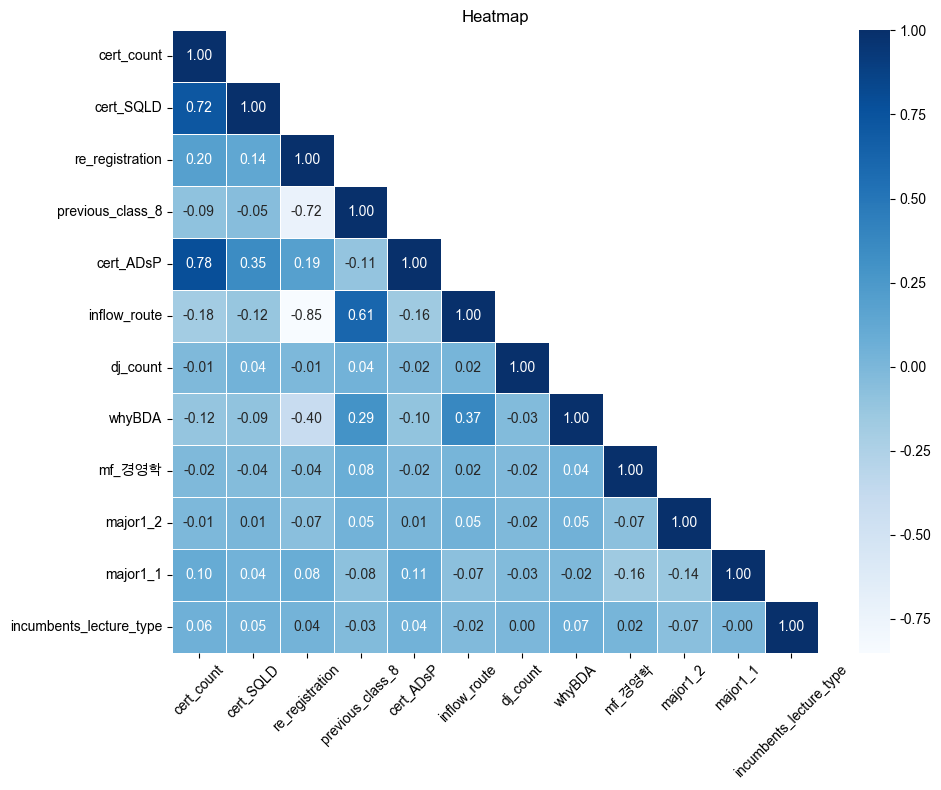

,column,method,correlation,p_value,abs_corr,significant
0,cert_count,spearman,0.1428,0.0001,0.1428,True
1,cert_SQLD,spearman,0.1247,0.0006,0.1247,True
2,re_registration,spearman,0.1215,0.0009,0.1215,True
3,previous_class_8,spearman,-0.1150,0.0016,0.1150,True
4,cert_ADsP,spearman,0.1104,0.0025,0.1104,True
5,inflow_route,spearman,-0.1058,0.0038,0.1058,True
6,dj_count,spearman,-0.1002,0.0061,0.1002,True
7,whyBDA,spearman,-0.0987,0.0069,0.0987,True
8,mf_경영학,spearman,-0.0958,0.0087,0.0958,True
9,major1_2,spearman,-0.0810,0.0267,0.0810,True


In [22]:
from src.preprocess.eda import AdvanceEDA
from src.visualization.plot import heatmap_plot 

# corr
Advance_eda = AdvanceEDA()
corr_df = Advance_eda.check_correlation(train, target='completed', method='auto')
true_corr = corr_df[corr_df['significant'] == True]
true_corr_cols = true_corr['column'].tolist()

heatmap_plot(train[true_corr_cols], mask='upper', cmap='Blues');
true_corr.reset_index(drop=True)

In [ ]:
# 1. 이전 기수 참여 횟수 (previous_class가 label encoding 되어있으므로 0이 아닌 값 카운트)                       
X_v3 = X_v2.copy()
test_v3 = test_v2.copy()

prev_cols = [c for c in X_v3.columns if c.startswith('previous_class_')]                                            
X_v3['prev_count'] = (X_v3[prev_cols] != 0).sum(axis=1)                                                                
test_v3['prev_count'] = (test_v3[prev_cols] != 0).sum(axis=1)                                                          
                                                                                                                
# 2. 재등록 멤버 여부 (prev_count > 0)                                                                           
X_v3['is_returning'] = (X_v3['prev_count'] > 0).astype(int)
test_v3['is_returning'] = (test_v3['prev_count'] > 0).astype(int)

# 3. 자격증 갭 (희망 - 보유 = 동기부여)
X_v3['cert_gap'] = X_v3['dcert_count'] - X_v3['cert_count']
test_v3['cert_gap'] = test_v3['dcert_count'] - test_v3['cert_count']

# 4. 관심사 다양성 (넓을수록 집중도 낮음 → 수료에 부정적)
X_v3['interest_diversity'] = X_v3['dj_count'] + X_v3['mf_count'] + X_v3['ed_count']
test_v3['interest_diversity'] = test_v3['dj_count'] + test_v3['mf_count'] + test_v3['ed_count']

# 5. 투입시간 / 이수학기 (학업 부담 대비 투입 의지)
X_v3['time_per_semester'] = X_v3['time_input'] / (X_v3['completed_semester'].abs() + 1)
test_v3['time_per_semester'] = test_v3['time_input'] / (test_v3['completed_semester'].abs() + 1)

# 6. 준비도 점수 (자격증 + 재등록)
X_v3['commitment'] = X_v3['cert_count'] + X_v3['re_registration']
test_v3['commitment'] = test_v3['cert_count'] + test_v3['re_registration']

print(f"Feature: {X_v2.shape[1]} → {X_v3.shape[1]}")

Feature: 96 → 102


정규성 만족 비율: 0.0% → SPEARMAN 선택


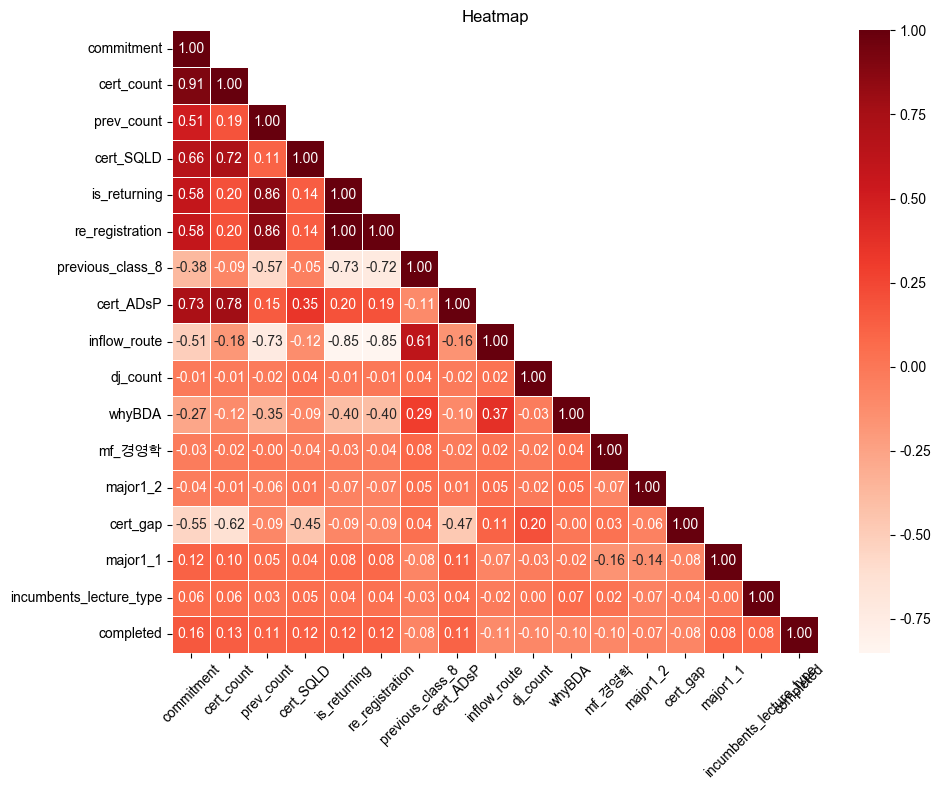

,column,method,correlation,p_value,abs_corr,significant
0,commitment,spearman,0.1630,0.0000,0.1630,True
1,cert_count,spearman,0.1428,0.0001,0.1428,True
2,prev_count,spearman,0.1268,0.0005,0.1268,True
3,cert_SQLD,spearman,0.1247,0.0006,0.1247,True
4,is_returning,spearman,0.1240,0.0007,0.1240,True
5,re_registration,spearman,0.1215,0.0009,0.1215,True
6,previous_class_8,spearman,-0.1150,0.0016,0.1150,True
7,cert_ADsP,spearman,0.1104,0.0025,0.1104,True
8,inflow_route,spearman,-0.1058,0.0038,0.1058,True
9,dj_count,spearman,-0.1002,0.0061,0.1002,True


In [23]:
train_v3 = X_v3.copy()                                                                                           
train_v3['completed'] = y                                                                                        
                                                                                                                
corr_df = Advance_eda.check_correlation(train_v3, target='completed', method='auto')                             
true_corr = corr_df[corr_df['significant'] == True]                                                              
true_corr_cols = true_corr['column'].tolist()                                                                    

heatmap_plot(train_v3[true_corr_cols + ['completed']], mask='upper', cmap='Reds')
true_corr.reset_index(drop=True)

In [24]:
comparator_v3 = ModelComparator(n_splits=10)
results_v3 = comparator_v3.run(X_v3, y)
results_v3

LightGBM: 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


  → LightGBM: OOF F1=0.4706, Mean Fold F1=0.5049±0.0366, Threshold=0.31


XGBoost: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


  → XGBoost: OOF F1=0.4053, Mean Fold F1=0.445±0.0512, Threshold=0.24


CatBoost: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


  → CatBoost: OOF F1=0.4825, Mean Fold F1=0.5063±0.0347, Threshold=0.47


RandomForest: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


  → RandomForest: OOF F1=0.4639, Mean Fold F1=0.5122±0.0339, Threshold=0.25


ExtraTrees: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  → ExtraTrees: OOF F1=0.4605, Mean Fold F1=0.4952±0.0412, Threshold=0.28


,name,oof_f1,mean_fold_f1,std_fold_f1,best_threshold
0,CatBoost,0.4825,0.5063,0.0347,0.47
1,LightGBM,0.4706,0.5049,0.0366,0.31
2,RandomForest,0.4639,0.5122,0.0339,0.25
3,ExtraTrees,0.4605,0.4952,0.0412,0.28
4,XGBoost,0.4053,0.4450,0.0512,0.24


In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_v3, y), n_trials=500, show_progress_bar=True)

print(f"Best F1: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

  0%|          | 0/500 [00:00<?, ?it/s]

[W 2026-02-14 21:52:22,698] Trial 10 failed with parameters: {'iterations': 2862, 'learning_rate': 0.03423787108375701, 'depth': 10, 'l2_leaf_reg': 1.292215866987208, 'border_count': 130, 'min_data_in_leaf': 40, 'subsample': 0.991968131497538, 'colsample_bylevel': 0.6517180392584612, 'scale_pos_weight': 2.1350174870186596, 'random_strength': 7.003480542935559, 'bagging_temperature': 9.379271290587853} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/mungughyeon/Documents/contest/DACON_BDA/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/0s/8dffxjb55g767y_3df067w080000gn/T/ipykernel_64808/3219915991.py", line 2, in <lambda>
    study.optimize(lambda trial: objective(trial, X_v3, y), n_trials=500, show_progress_bar=True)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/0s/8dffx

KeyboardInterrupt: 

### Ensamble

In [20]:
from sklearn.metrics import f1_score                                                                             
                                                                                                            
top2 = ['CatBoost', 'LightGBM']
top2_idx = [2, 0]  # 생성 순서: LGB=0, XGB=1, Cat=2, RF=3, ET=4

print("개별 모델:")
for i, name in zip(top2_idx, top2):
    m = comparator.models[i]
    _, f1 = m._find_best_threshold(y, m.oof_preds)
    print(f"  {name}: OOF F1={f1:.4f}, Threshold={m.best_threshold:.2f}")

oof_blend = np.mean([comparator.models[i].oof_preds for i in top2_idx], axis=0)
best_t, best_f1 = 0.5, 0.0
for t in np.arange(0.10, 0.60, 0.01):
    f1 = f1_score(y, (oof_blend >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"\nBlending OOF F1: {best_f1:.4f}, Threshold: {best_t:.2f}")

개별 모델:
  CatBoost: OOF F1=0.4856, Threshold=0.47
  LightGBM: OOF F1=0.4692, Threshold=0.28

Blending OOF F1: 0.4912, Threshold: 0.39


In [ ]:
probs = comparator.predict_proba(test)
top3_prob = np.mean([probs['CatBoost'], probs['LightGBM'], probs['RandomForest']], axis=0)

from sklearn.metrics import f1_score                                                                             
from scipy.stats import rankdata